In [1]:
from ScriptFiles import DataCleaning_and_Prediction as dc
from ScriptFiles import DataRead_and_PreClean as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
 

In [2]:
#############################################################################
### Function to plot Data profile in terms of fuelvoltage, Distance over time

def plotData_profiles(df):
    plt.rcParams['figure.figsize'] = [16, 12]

    #### 1. Checking order of Data, as per datetime
    plt.subplot(3,1,1)
    plt.plot(df.index, df.datetime, 'g.', markersize=1, linewidth=1);

    plt.subplot(3,1,2)
    plt.plot(df.index, df.fuelVoltage, 'g.', markersize=2, linewidth=1);

    plt.subplot(3,1,3)
    plt.plot(df.index, df.distance, 'g-', markersize=2, linewidth=1);
    plt.title("Cumulative Distance vs Time", fontsize=15)
    plt.show()

In [28]:
#######################################################
### Function to Plot theft Points over Cleaned Data

def plot_theftpts(cleanedDf , theftpts = [], xlim=[], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize'] = [20, 4]
    # plt.subplot(6,1,1)
    fig, ax1 = plt.subplots()
    ax1.plot(cleanedDf.index, cleanedDf.fuelVoltage, 'g.', markersize=2, linewidth=1)
    ax1.set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('FuelVoltage', color='b')
    ax1.tick_params('y', colors='b')
    if len(ylim1)!=0:
        ax1.set_ylim(ylim1)

    ax2 = ax1.twinx()
    ax2.plot(cleanedDf.index, cleanedDf.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        ax2.set_ylim(ylim2)
    plt.title("Initial Prediction theft Points - ZOOMED")
    if len(xlim) !=0:
        plt.xlim(xlim)
    
    for pt in theftpts:
        plt.axvline(pt)
    plt.show()


In [53]:
def plot_Results(df, df_clean, result_df, xlim = [], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize']=[16,12]
    plt.subplot(4, 1, 1)
    plt.plot(df.datetime, df.fuelVoltage, 'g.', markersize=1, linewidth=1);
    #plt.plot(df.datetime, df.distance, 'b-', markersize=1, linewidth=1);
    plt.title('Original FuelData vs Time')

    plt.subplot(4, 1, 2)
    
    fig, ax1 = plt.subplots()
    ax1.plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    ax1.set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('FuelVoltage', color='b')
    ax1.tick_params('y', colors='b')
    if len(ylim1)!=0:
        ax1.set_ylim(ylim1)

    ax2 = ax1.twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        ax2.set_ylim(ylim2)
    if len(xlim) !=0:
        plt.xlim(xlim)
    plt.title('Cleaned Data')
    
    plt.subplot(4, 1, 3)
    fig, ax1 = plt.subplots()
    ax1.plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    ax1.set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('FuelVoltage', color='b')
    ax1.tick_params('y', colors='b')
    if len(ylim1)!=0:
        ax1.set_ylim(ylim1)

    ax2 = ax1.twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        ax2.set_ylim(ylim2)
        
    if len(xlim) !=0:
        plt.xlim(xlim)
    plt.title('Final Predicted Theft Pts - ZOOMED')

    for pt in result_df.theft_index:
        plt.axvline(pt)

    plt.subplot(4, 1, 4)
    plt.plot(result_df.theft_index, result_df['fuel_jump'], 'g-', markersize=3, linewidth=1);
    plt.title('Fuel/km Ratio at Predicted theft pts - ZOOMED')

#     if len(xlim) !=0:
#         plt.xlim(xlim)
#     if len(ylim)!=0:
#         plt.ylim(ylim)

    #plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);

    plt.show()

In [57]:
folderpath = r"G:\Analytics\FuelAnalysis\test2"
savePath = r"G:\Analytics\FuelAnalysis\results"
filepath = r""
fuelMax = 100
df_list, filesname = dr.read__MultipleCSVs(folder_path= folderpath, nfiles=4)
ctr = 0
def formatDf(df):
    #df_list[0].info()
    df = dr.perform_PreFormating(df)
    print ("Dataset_"+str(ctr+1) +" Preformatting Done")

    dff = dr.perform_postFormating(df)
    print("Dataset_" + str(ctr + 1) + " Postformatting Done")
    return dff

def cleanDF(dff):
    df_clean = dc.Clean_NoiseData(dff, level= 6)
    print("Dataset_" + str(ctr + 1) + " Data Cleaning Done")
    return df_clean

def findtheft(df_clean):
    theft_pts = dc.theft_point(df_clean, tlevel= 0.01)
    print("Dataset_" + str(ctr + 1) + " Theft points Indentified")
    return theft_pts

    

G:\Analytics\FuelAnalysis\test2\cordinates_007042639339.csv
G:\Analytics\FuelAnalysis\test2\cordinates_007042640749.csv
G:\Analytics\FuelAnalysis\test2\cordinates_007042641148.csv
G:\Analytics\FuelAnalysis\test2\cordinates_008527948598.csv


In [59]:
#plotData_profiles(df)
df = df_list[2]
df = df[:]
df = df.reset_index(drop= True)
df.st = df.io_state.apply(lambda x: x[1])
dis = df[df.st == '0'].distance.apply(lambda x: int(x))

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


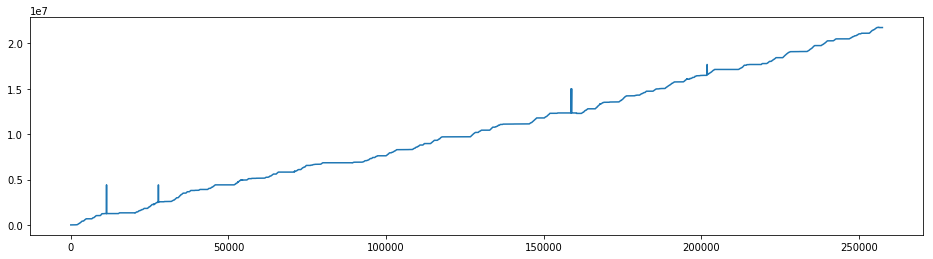

In [60]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dis)

In [61]:
dff = formatDf(df.copy())
Dmax = dff.distance.max()

Dataset_1 Preformatting Done
Dataset_1 Postformatting Done


In [62]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53428 entries, 0 to 53427
Data columns (total 7 columns):
datetime       53428 non-null datetime64[ns]
lat            53428 non-null float64
long           53428 non-null float64
speed          53428 non-null float64
distance       53428 non-null float64
fuelVoltage    53428 non-null float64
dev_state      53428 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 2.9 MB


In [63]:
sum(dff[dff.dev_state==0].fuelVoltage <3)

0

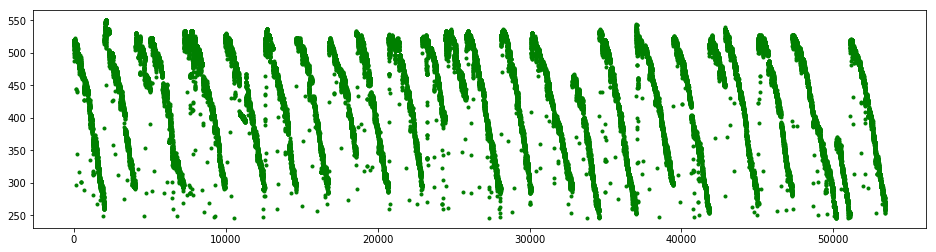

In [64]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dff.index, dff.fuelVoltage,'g.');


In [65]:
dff.fuelVoltage.median()

439.0

In [66]:
dff.fuelVoltage.std()

77.1026587467118

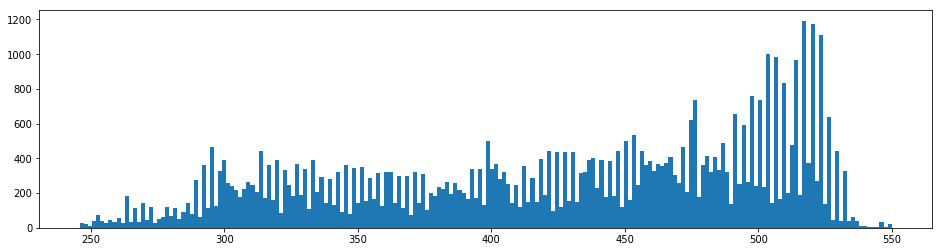

In [67]:
plt.rcParams['figure.figsize'] = [16,4]
plt.hist(dff.fuelVoltage,200);
#plt.xlim(0,0.02)
#plt.ylim(0,2.5)

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


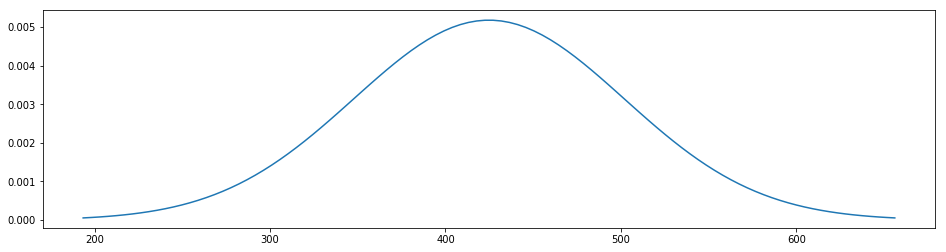

In [68]:
import matplotlib.mlab as mlab
mu = dff.fuelVoltage.mean()
#variance = (dff.fuelVoltage.std())*(dff.fuelVoltage.std())
sigma = dff.fuelVoltage.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))

In [69]:
dff[(dff.fuelVoltage == 0)  & (dff.dev_state == 1)]

,datetime,lat,long,speed,distance,fuelVoltage,dev_state


In [70]:
df_clean = cleanDF(dff.copy())

Dataset_1 Data Cleaning Done


In [71]:
theft_pts = findtheft(df_clean)

**
281
Dataset_1 Theft points Indentified


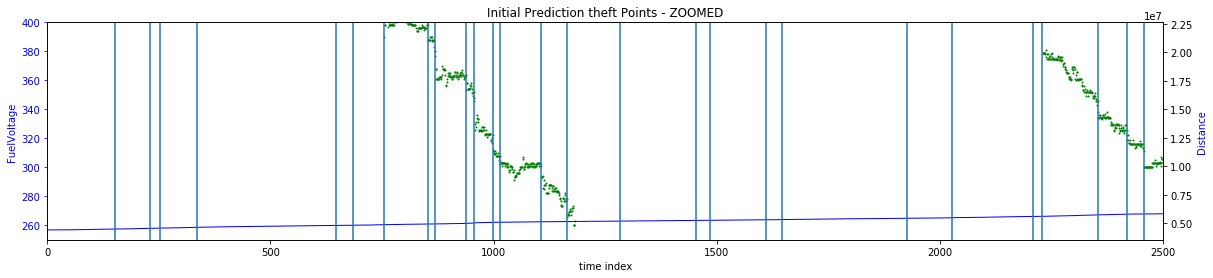

0


In [74]:
xlim = [0,2500]
ylim = [250,400]
plot_theftpts(df_clean,theft_pts, xlim = xlim, ylim1= ylim)
result_df = dc.generate_PredictTable(df_clean,theft_pts,float(Dmax), fuelMax)

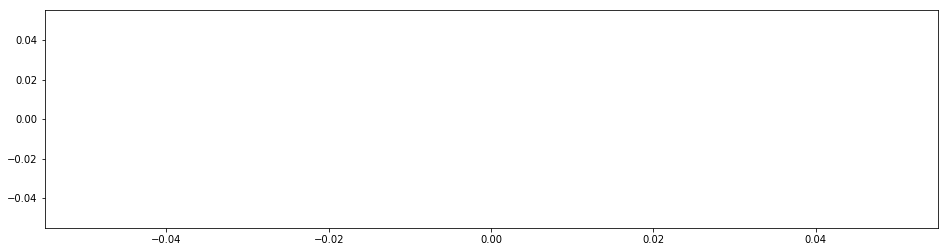

In [77]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(result_df.theft_index, result_df['fuel_jump'], 'g-', markersize=3, linewidth=1);
#plt.ylim(0,400)

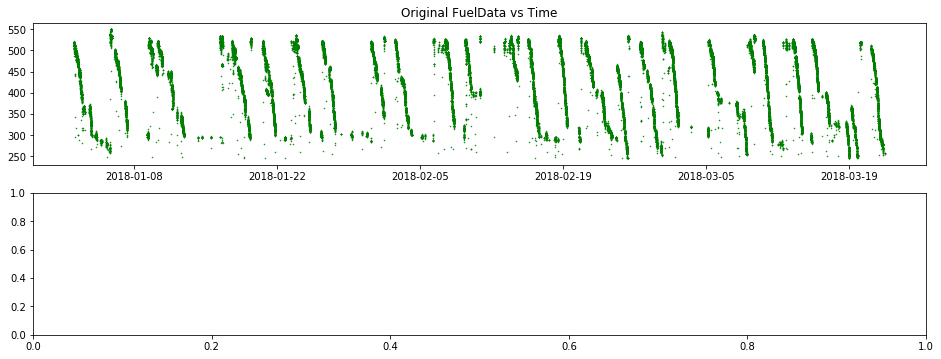

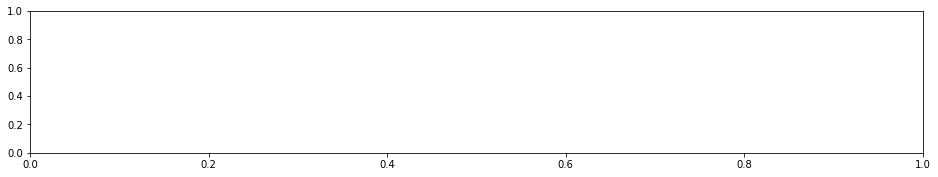

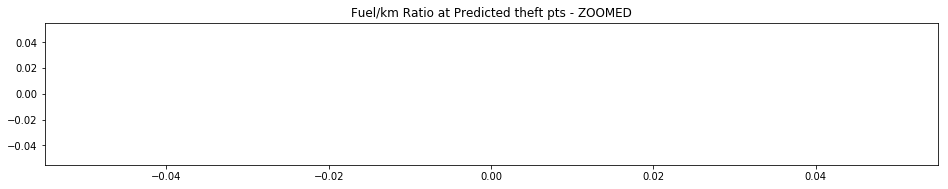

Empty DataFrame
Columns: [theft_index, lat, long, theft_time, fuel_jump, dist_jump(KM), time_jump, Possibility, FuelPerKM]
Index: []


In [76]:
#build_savePath = savePath + r"\result_dataset_" + filesname[ctr].replace(folderpath,"").replace('\\', "")
#result_df.to_csv(build_savePath)

plot_Results(dff,df_clean,result_df, xlim = xlim, ylim1=[])
#ctr+=1
print(result_df)

In [ ]:
def findAVG(cleanDf, Dmax):
    i = 0
    ds = 0
    df = 0
    dsRef = 0
    avgDT = []
    dt = 100
    mean_lst = []
    median_lst = []
    mode_lst = []
    ctr = 0
    print(Dmax)
    while dt < Dmax:
        avgDT = []
        #print (dt)
        i=0
        while i<len(cleanDf): 
            ds = 0
            dsRef = cleanDf.distance[i]
            dfRef = cleanDf.fuelVoltage[i]
            while ((ds)<=dt  and i<len(cleanDf)):
                ds = (cleanDf.distance[i] - dsRef)*float(Dmax)
                i+=1
                #print(i)

            if i<len(cleanDf):
                df = dfRef- cleanDf.fuelVoltage[i]
                if df>0 :
                    avg = df
                    avgDT.append(avg)
            #print(df)
        med = pd.Series(avgDT).median()
        mean = pd.Series(avgDT).mean()
        mode = pd.Series(avgDT).mode()
        #print (med,mean,mode)

        median_lst.append(med)
        mean_lst.append(mean)
        mode_lst.append(mode)
        ctr+=1
        dt += ctr*100
        print (dt)

        
    return pd.Series(avgDT), [median_lst,mean_lst,mode_lst]

avgDT, central_DT = findAVG(df_clean, Dmax)

In [ ]:
len(df_clean), Dmax

In [ ]:
#dt = [i*100 for (i,dt) in zip(len(central_DT[0]),Dmax) ]
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.plot(central_DT[0]);
plt.subplot(3,1,2)
plt.plot(central_DT[1]);
plt.subplot(3,1,3)
#plt.plot(central_DT[2]);

        

In [ ]:
(central_DT[0])

In [ ]:
plt.hist(avgDT[abs(avgDT - avgDT.mean()) < 3*avgDT.std()],bins = 200)
plt.axvline(avgDT.median(), color = 'black')
plt.axvline(avgDT.mean(), color = 'green')

In [ ]:
a = avgDT.value_counts()
avgDT.median(), avgDT.mean(), avgDT.mode()

10km:
mean = 0.0167
median = 0.0131
mode = 0.0037

1km:
mean = 0.0095
median = 0.00562
mode = 0.00187

5km:
mean = 0.00138
median = 0.00936
mode = 0.00187

0.5Km
mean = 0.00138
median = 0.00936
mode = 0.00187

50km
mean = 0.0373
median = 0.0365
mode = 0.0411

100km
mean = 0.065988
median = 0.0692
mode = 0.048689









In [ ]:
plt.plot(df_clean.distance * .001*Dmax, df_clean.fuelVoltage,  'g.')